# ISOKANN example with Feedforward Neural Network
ISOKANN is an algorithm that uses machine learning techniques to identify invariant subspaces of the Koopman operator.
The following implementation is based on the original ISOKANN version described in Ref. [1] and summarized in Ref. [2].

This version of ISOKANN introduces improvements over the version in the top folder.
Important features:

- Torch-based
- The main functions are collected in classes and functions in the modules directory
- Random search is used to optimise hyperparameters
- Early stopping
- A validation test is introduced
- The power method stops if convergence is below a certain threshold
  
__References__

[1] R. J. Rabben, S. Ray, M. Weber; ISOKANN: Invariant subspaces of Koopman operators learned by a neural network. 
[J. Chem. Phys. 153, 114109 (2020)](https://pubs.aip.org/aip/jcp/article-abstract/153/11/114109/199583/ISOKANN-Invariant-subspaces-of-Koopman-operators)

[2] L. Donati; [Notes about ISOKANN algorithm](https://www.zib.de/userpage/donati/SeminarSOSE2024/06/lecture_notes/L06.pdf)

In [1]:
import numpy as np
import sympy as sp
import torch as pt
from tqdm import tqdm
import scipy 
import random
from sklearn.model_selection import train_test_split
import sys
import matplotlib.pyplot as plt

In [7]:
x      =  sp.symbols('x')

def discretize_axis(xmin, xmax, xbins):
    """
    xcenters, xedges, xbins, dx = discretize_axis(xmin, xmax, xbins)
    """

    xedges   = np.linspace(xmin, xmax, xbins) 
    dx       = xedges[1] - xedges[0]
    xcenters = xedges + 0.5 * dx
    xcenters = np.delete(xcenters,-1)
    xbins    = len(xcenters)

    return xcenters, xedges, xbins, dx


class Potential1D_car:
    def __init__(self, 
                 V   = (x**2 - 1) ** 2 
                ):
        
        """
        ... 
        """    
        display(V)
        dVx = V.diff(x)
        
        self.V    = sp.lambdify((x), V,   modules=['numpy'])
        self.dVx  = sp.lambdify((x), dVx, modules=['numpy'])


class SystemParameters:
    def __init__(self, 
                 Ndims  = 1, 
                 mass   = np.array([1.0]), 
                 gamma  = np.array([1.0]), 
                 kB     = 0.008314463, # kJ mol^-1 K^-1
                 T      = 300 # K              
                ):
        
        """
        ... 
        """        
        
        self.Ndims = Ndims
        self.mass  = mass
        self.gamma = gamma
        self.kB    = kB
        self.T     = T
        self.beta  = 1 / kB / T # kJ^-1

def scale_and_shift(y):
    """
    scale and shift function for the modified power method
    """
    minarr = np.min(y)
    maxarr = np.max(y)
    hat_y  = (y - minarr) / (maxarr - minarr)

    return hat_y

def exit_rates_from_chi(tau, chi_0, chi_tau):
    
    #
    chi1      = chi_0[:,0]
    chi2      = chi_0[:,1]

    #
    prop_chi1 = chi_tau[:,0]
    prop_chi2 = chi_tau[:,1]

    res1 = scipy.stats.linregress(chi1, prop_chi1)
    res2 = scipy.stats.linregress(chi2, prop_chi2)

    rate1  = - 1 / tau * np.log( res1.slope ) * ( 1 + res1.intercept  / ( res1.slope - 1 ))
    rate2  = - 1 / tau * np.log( res2.slope ) * ( 1 + res2.intercept  / ( res2.slope - 1 ))
    
    #
    print(r"$a_{1,1} =$", res1.slope)
    print(r"$a_{1,2} =$", res1.intercept)
    print(" ")
    print(r"$a_{2,1}=$", res2.slope)
    print(r"$a_{2,2} =$", res2.intercept)
    print(" ")
    print('Exit rate 1:', rate1)
    print('Exit rate 2:', rate2)

    return rate1, rate2


class NeuralNetwork(pt.nn.Module):
    def __init__(self, Nodes, enforce_positive=0):
        super(NeuralNetwork, self).__init__()

        # self parameters
        self.input_size        = Nodes[0]
        self.output_size       = Nodes[-1]
        self.NhiddenLayers     = len(Nodes) - 2
        self.Nodes             = Nodes
        
        self.enforce_positive  = enforce_positive

        # build NN architecture
        self.hidden_layers = pt.nn.ModuleList()

        # add layers
        self.hidden_layers.extend([pt.nn.Linear(self.input_size,    self.Nodes[1])])
        self.hidden_layers.extend([pt.nn.Linear(self.Nodes[1+l], self.Nodes[1+l+1]) for l in range(self.NhiddenLayers)])

        # the output of the last layer must be equal to 1
        #if self.Nodes[-1] > 1:
        #    self.hidden_layers.extend([pt.nn.Linear(self.Nodes[-1], 1)])

        # define activation function
        self.activation1  = pt.nn.Sigmoid()  # #
        self.activation2  = pt.nn.ReLU() 
        self.activation3  = pt.nn.Softplus(10)
        
    def forward(self, X):

        # Pass input through each hidden layer but the last one
        for layer in self.hidden_layers[:-1]:
            X = self.activation1(layer(X))

        # Apply the last layer (but not the activation function)
        X = self.hidden_layers[-1](X)

        if self.enforce_positive == 1:
            X= self.activation3(X)  #.unsqueeze(1)

        return X.squeeze()

def trainNN(net, 
            lr, 
            wd, 
            Nepochs, 
            batch_size, 
            X, 
            Y,
            test_size = 0.2
           ):

    # Early stopping parameters
    # Stop training if this metric no longer improves after a certain number of epochs (patience).
    patience = 10
    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    # Split training and validation data
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=test_size, random_state=42)
    
    # Define the optimizer
    optimizer = pt.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    #optimizer = pt.optim.SGD(net.parameters(), lr=lr, weight_decay=wd, nesterov=True, momentum=0.23, dampening=0)

    # Define the loss function
    MSE = pt.nn.MSELoss()
        
    # Define an array where to store the loss
    train_losses = []
    val_losses = []

    # Train the model
    for epoch in range(Nepochs):

        permutation = pt.randperm(X_train.size()[0], device=device)

        for i in range(0, X_train.size()[0], batch_size):
            
            # Clear gradients for next training
            optimizer.zero_grad()
            
            indices = permutation[i:i+batch_size]
            
            batch_x, batch_y = X_train[indices], Y_train[indices]
            
            # Make a new prediction
            new_points  =  net( batch_x )
            
            # measure the MSE
            loss = MSE(batch_y, new_points)

            # computes the gradients of the loss with respect to the model parameters using backpropagation.
            loss.backward()

            # updates the NN parameters
            optimizer.step()

        train_losses.append(loss.item())

        # Validation
        with pt.no_grad():
            val_outputs = net(X_val)
            val_loss    = MSE(val_outputs, Y_val)
            val_losses.append(val_loss.item())

        # Early stopping
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = net.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                #print(f"Early stopping at epoch {epoch+1}")
                break
        
        #print(f'Epoch {epoch+1}/{Nepochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    return train_losses, val_losses, best_loss


# Random search for hyperparameters
def random_search(  
                    X, 
                    Y, 
                    NN_layers, 
                    learning_rates, 
                    weight_decays, 
                    batch_size=50, 
                    search_iterations=20,
                    test_size = 0.2
                ):

    best_hyperparams = None
    best_val_loss = float('inf')

    for _ in tqdm(range(search_iterations)):

        lr    = random.choice(learning_rates)
        nodes = np.asarray(random.choice(NN_layers))
        wd    = random.choice(weight_decays)

        print("Testing learning rate =", lr)
        print("Testing weight decays =", wd)

        print("Testing layers =", nodes)

        f_NN = NeuralNetwork( Nodes = nodes ).to(device)

        train_losses, val_losses, val_loss = power_method(X, Y, 
                                                          f_NN, 
                                                          scale_and_shift, 
                                                          Niters = 100, 
                                                          Nepochs = 100,
                                                          tolerance  = 5e-3, 
                                                          batch_size=batch_size,
                                                          lr = lr,
                                                          wd = wd,
                                                          test_size = test_size)

        print("Validation loss:", val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            
            best_hyperparams = {'nodes': nodes, 'learning_rate': lr, 'weight_decay': wd}

        del f_NN

    return best_hyperparams, best_val_loss


def power_method(   pt_x0, 
                    pt_xt, 
                    f_NN, 
                    scale_and_shift, 
                    Niters = 500, 
                    Nepochs = 10, 
                    lr = 1e-3, 
                    wd = 0,
                    batch_size = 50,
                    tolerance  = 5e-3,                     
                    test_size = 0.2,
                    print_eta=False
                ):

    """
    train_LOSS, val_LOSS, best_loss = power_method(pt_x0, pt_y, f_NN, scale_and_shift, Niters = 500, tolerance  = 5e-3)
    """
    train_LOSS = np.empty(0, dtype = object)
    val_LOSS   = np.empty(0, dtype = object)

    if   print_eta == False:
        loop = range(Niters)
    elif print_eta == True:
        loop = tqdm(range(Niters))
        
    for i in loop:

        old_chi =  f_NN(pt_x0).cpu().detach().numpy()

        pt_chi  =  f_NN( pt_xt )
        pt_y    =  pt.mean(pt_chi, axis=1)
        y       =  scale_and_shift(pt_y.detach().cpu().detach().numpy())
        pt_y    =  pt.tensor(y, dtype=pt.float32, device = device)
        
        train_loss, val_loss, best_loss = trainNN(net      = f_NN, 
                                                  lr       = lr, 
                                                  wd       = wd, 
                                                  Nepochs    = Nepochs, 
                                                  batch_size = batch_size,
                                                  test_size  = test_size, 
                                                  X          = pt_x0, 
                                                  Y          = pt_y)

        train_LOSS           = np.append(train_LOSS, train_loss[-1]) #[-1]
        val_LOSS             = np.append(val_LOSS, val_loss[-1])     # [-1]

        new_chi   = f_NN(pt_x0).cpu().detach().numpy()
        #print(np.linalg.norm(new_chi - old_chi) )
        if np.linalg.norm(new_chi - old_chi) < tolerance:
            
            break

    return train_LOSS, val_LOSS, best_loss


Torch is on: cpu
Thermal energy: 2.4943389


10*(x**2 - 1)**2

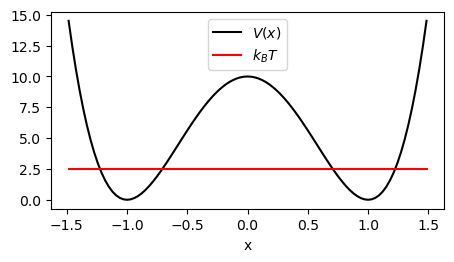

In [8]:
# Check if CUDA is available, otherwise use CPU
device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
print(f"Torch is on: {device}")

# For reproducibility
np.random.seed(0)
pt.manual_seed(0)

# For figures
font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# System parameters
SPs  = SystemParameters()


print("Thermal energy:", SPs.kB * SPs.T)

# Potential energy function
P1D = Potential1D_car( 10*(x**2 - 1)**2 )

## Plot potential
ax, xedges, xbins, dx = discretize_axis(-1.5, 1.5, 100)

fig = plt.figure(figsize=(10*in2cm, 5*in2cm))

plt.plot(ax, P1D.V(ax), 'k-', label = r'$V(x)$')
plt.plot(ax, SPs.kB * SPs.T * np.ones(xbins),'r', label = r'$k_B T$')
plt.legend()
plt.xlabel('x')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.5)
#fig.savefig('potential.png', format='png', dpi=300, bbox_inches='tight')

Load the data set of initial points $x_0$.
Load the data set of final points $x_t$.

In [9]:
# Load initial points
x0 = np.loadtxt('x0.txt')
print("x0.shape =", x0.shape)

Npoints = len(x0)
print("Npoints = ", Npoints)

# Load final points
xt = np.loadtxt('xt.txt')
print("xt.shape =", xt.shape)

Npoints      = xt.shape[0]  # == len(x0)
Nfinpoints   = xt.shape[1]
print("Nfinpoints = ", Nfinpoints)


# Length of each trajectory (this information is used later for rate estimation)
Nsteps = 200
# Integrator time step used for simulations
dt     = 0.001

x0.shape = (200,)
Npoints =  200
xt.shape = (200, 300)
Nfinpoints =  300


  0%|          | 0/5 [00:00<?, ?it/s]

Testing learning rate = 0.01
Testing weight decays = 1e-06
Testing layers = [ 1 32  1]


 20%|██        | 1/5 [00:09<00:39,  9.80s/it]

Validation loss: tensor(9.7915e-05)
Testing learning rate = 0.01
Testing weight decays = 0.0001
Testing layers = [ 1 64  1]


 40%|████      | 2/5 [00:19<00:29,  9.80s/it]

Validation loss: tensor(0.0005)
Testing learning rate = 0.0001
Testing weight decays = 0.0001
Testing layers = [ 1 64  1]


 60%|██████    | 3/5 [00:22<00:13,  6.56s/it]

Validation loss: tensor(0.0058)
Testing learning rate = 0.0001
Testing weight decays = 1e-06
Testing layers = [  1 128   1]


 80%|████████  | 4/5 [00:28<00:06,  6.57s/it]

Validation loss: tensor(0.0049)
Testing learning rate = 0.01
Testing weight decays = 1e-05
Testing layers = [ 1 64 32  1]


100%|██████████| 5/5 [00:49<00:00,  9.92s/it]


Validation loss: tensor(0.0001)
The best hyperparameters are: {'nodes': array([ 1, 32,  1]), 'learning_rate': 0.01, 'weight_decay': 1e-06}


 66%|██████▌   | 328/500 [00:22<00:11, 14.87it/s]


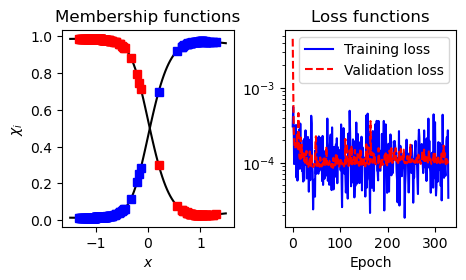

In [10]:
# This cell implements the modified power method 

# Convert x0 and add one dimension, such that pt_x0.shape = (Npoints, 1)
pt_x0     =  pt.tensor(x0, dtype=pt.float32, device=device).unsqueeze(1)

# Convert xt and add one dimension, such that pt_xt.shape = (Npoints, Nfinpoints, 1)
pt_xt     =  pt.tensor(xt, dtype=pt.float32, device=device).unsqueeze(2)

# Find the optimal hyperparameters using random search
NN_layers =          [(SPs.Ndims, 32, 1), 
                      (SPs.Ndims, 64, 1), 
                      (SPs.Ndims, 128, 1),
                      (SPs.Ndims, 128, 64, 1), 
                      (SPs.Ndims, 64, 32, 1)]

learning_rates = [0.01, 
                  0.001, 
                  0.0001]

weight_decays  = [0.0001, 
                  0.00001, 
                  0.000001]

best_hyperparams, best_val_loss = random_search(pt_x0, 
                                                pt_xt, 
                                                NN_layers, 
                                                learning_rates, 
                                                weight_decays, 
                                                search_iterations=5,
                                                test_size = 0.2)

print("The best hyperparameters are:", best_hyperparams)

nodes = best_hyperparams['nodes']
lr    = best_hyperparams['learning_rate']
wd    = best_hyperparams['weight_decay']

# Define the interpolating function
f_k = NeuralNetwork( Nodes = np.asarray(nodes), enforce_positive = 1 )

# Apply the power method using the best hyperparameters
train_LOSS, val_LOSS, best_loss = power_method(pt_x0, 
                                               pt_xt, 
                                               f_k, 
                                               scale_and_shift, 
                                               Niters = 500, 
                                               Nepochs = 100,
                                               tolerance  = 5e-3, 
                                               lr = lr,
                                               wd = wd,
                                               batch_size = 50,  
                                               print_eta  = True,
                                               test_size = 0.2
                                              )

pt_ax  =  pt.tensor(ax, dtype=pt.float32).unsqueeze(1)
y      =  f_k(pt_ax).cpu().detach().numpy()
chi    =  f_k(pt_x0).cpu().detach().numpy()

## Plot chi function and loss functions
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10*in2cm, 5*in2cm))

ax1.plot(ax, y, 'k')
ax1.plot(ax, 1-y, 'k')

ax1.plot(x0, chi,   'sb')
ax1.plot(x0, 1-chi,   'sr')

ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$\chi_i$')
ax1.set_title('Membership functions')

#ax.set_ylim(-0.1,1.1);

ax2.plot(train_LOSS, 'b', label='Training loss')
ax2.plot(val_LOSS,   'r--', label='Validation loss')

ax2.set_xlabel('Epoch')
ax2.set_title('Loss functions')
#ax.set_ylim(0,0.01)
ax2.set_yscale('log')
ax2.legend()

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.5)
fig.savefig('chi_1D.png', format='png', dpi=300, bbox_inches='tight')

In [11]:
chi_0   = f_k(pt_x0).cpu().detach().numpy()
y       = f_k(pt_xt).cpu().detach().numpy()
chi_tau = np.mean( y, axis=1 )

chi_0         = np.array([chi_0,      1 - chi_0]).T
chi_tau       = np.array([chi_tau,    1 - chi_tau]).T


rate1, rate2  = exit_rates_from_chi(Nsteps * dt, chi_0, chi_tau)

$a_{1,1} =$ 0.9416322654610098
$a_{1,2} =$ 0.026985455282145243
 
$a_{2,1}=$ 0.941632266922631
$a_{2,2} =$ 0.03138227820711559
 
Exit rate 1: 0.16167704904320088
Exit rate 2: 0.13902523368207031
